In [42]:
# install sompy (use our forked version - the original one has visualization bugs)
#!conda install git

!pip install -U git+https://github.com/joaopfonseca/Data-Mining-21-22
# IF THIS IT TAKING TOO LONG, TRY TO INSTALL IT FROM THE ANACONDA PROMPT

  Cloning https://github.com/joaopfonseca/Data-Mining-21-22 to c:\users\tsoom\appdata\local\temp\pip-req-build-xn0tl1j1
  Resolved https://github.com/joaopfonseca/Data-Mining-21-22 to commit dbff6150adff5cc37dc87cf9aa157f320f9e3b45


  Running command git clone --filter=blob:none -q https://github.com/joaopfonseca/Data-Mining-21-22 'C:\Users\tsoom\AppData\Local\Temp\pip-req-build-xn0tl1j1'
ERROR: git+https://github.com/joaopfonseca/Data-Mining-21-22 does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [26]:
from IPython.display import YouTubeVideo

from os.path import join
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier

import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView

## Import preprocessed data

In [27]:
df = pd.read_csv(join('..', 'data', 'tugas_preprocessed.csv'))

In [28]:
df.head()

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,...,x1_Widow,x2_M,x3_1.0,x4_Kind of OK,x4_Meh...,x4_OK nice!,x4_Take my money!!,PC0,PC1,PC2
0,0.743162,1.191605,0.457819,-0.617023,-0.243065,1.216847,0.495837,-0.499274,-1.257560,0.522055,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.896356,1.937697,-1.120781
1,1.559488,1.100011,-1.535723,0.166160,-0.790228,0.740464,-0.374374,-0.631907,-1.798649,-0.237578,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.981092,1.421498,-0.785625
2,-1.548542,-0.823463,0.557496,-0.834573,1.672006,-0.371096,-0.809480,2.286023,0.906799,-0.904191,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,-2.813108,-0.381440,0.780867
3,0.845528,0.550447,-1.402820,0.383710,0.440889,-0.768082,-0.084304,-0.234007,-0.391816,0.785568,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.247013,0.514177,1.302203
4,0.782435,1.008417,-0.871209,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,-0.445925,1.237135,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.781920,0.704805,0.443376


In [29]:
df.columns

Index(['income', 'frq', 'rcn', 'clothes', 'kitchen', 'small_appliances',
       'toys', 'house_keeping', 'per_net_purchase', 'spent_online',
       'x0_2nd Cycle', 'x0_Graduation', 'x0_Master', 'x0_PhD', 'x1_Married',
       'x1_Single', 'x1_Together', 'x1_Widow', 'x2_M', 'x3_1.0',
       'x4_Kind of OK', 'x4_Meh...', 'x4_OK nice!', 'x4_Take my money!!',
       'PC0', 'PC1', 'PC2'],
      dtype='object')

In [30]:
# Splitting feature names into groups
non_metric_features = df.columns[df.columns.str.startswith('x')]
pc_features = df.columns[df.columns.str.startswith('PC')]
metric_features = df.columns[~df.columns.str.startswith('x') & ~df.columns.str.startswith('PC')]

## Self-organizing maps
What is a SOM? How does it work? What is it used for?

The SOM objective is to adjust the units to the data in the input space, so that the
network is (as best as possible) representative of the training dataset.

### How is it computed?
### Important concepts:
- Units and observations
- BMU
- Neighborhood function
- Input and Output space

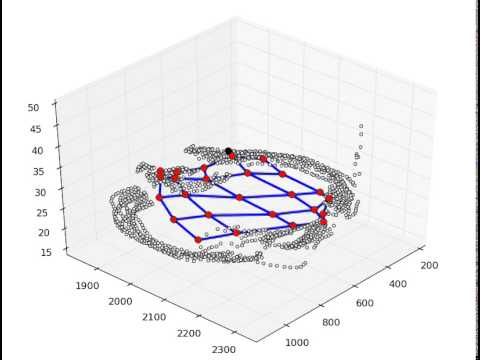

In [31]:
YouTubeVideo('k7DK5fnJH94')

### Characteristics:
- Grid shape needs to be set a priori
- Results depend on the initialization (even tough it can be quite robust to it)
- Fitting a SOM can be computationally expensive
- Capable of finding the global optimum (theoretically - if the LR -> 0)
- Visualization tool for high-dimensional data

### Additional analyses/tutorials
- [Air Flights](https://github.com/sevamoo/SOMPY/blob/master/sompy/examples/AirFlights_hexagonal_grid.ipynb)
- [Visualizations on toy datasets](https://gist.github.com/sevamoo/035c56e7428318dd3065013625f12a11)

### How to apply Self-Organizing Maps?

The training of a SOM is **more effective** if it is done in two phases: the unfolding phase, and the fine-tuning phase. 

In the **unfolding phase** the objective is to **spread the units** in the region of the input space where the data patterns are located. In this phase the neighbourhood function should have a large initial radius so that all units have high mobility and the map can quickly cover the input space.

The **fine tuning phase**, as the name implies, is the process of small adjustments in order to **reduce the quantization error**, and centre the units in the areas where the density of patterns is highest. Usually, in this phase the learning rate and the neighbourhood radius are smaller than the ones used in the unfolding phase. As these two parameters are smaller, the map will need more time to adjust its weights and that is why the number of iterations or epochs is normally higher.

**Exercise**
- Train a SOM with a 10x10 grid, random initialization, gaussian neighborhood function and hexagonal topology/lattice
- Set an unfolding phase and a fine tuning phase of 100 iterations

In [32]:
# This som implementation does not have a random seed parameter
# We're going to set it up ourselves
np.random.seed(42)

sm = sompy.SOMFactory().build(
        df[metric_features].values, 
        mapsize=[10,10],
        initialization='random', 
        neighborhood='gaussian',
        training='batch',
        lattice='rect',
        component_names=metric_features
)

sm.train(n_job=4, verbose='info', train_rough_len=100, train_finetune_len=50)

 Training...
 random_initialization took: 0.001000 seconds
 Rough training...
 radius_ini: 4.000000 , radius_final: 1.000000, trainlen: 100

 epoch: 1 ---> elapsed time:  0.025000, quantization error: 3.682456

 epoch: 2 ---> elapsed time:  0.027000, quantization error: 2.681483

 epoch: 3 ---> elapsed time:  0.027000, quantization error: 2.246900

 epoch: 4 ---> elapsed time:  0.025000, quantization error: 2.141013

 epoch: 5 ---> elapsed time:  0.025000, quantization error: 2.122854

 epoch: 6 ---> elapsed time:  0.027000, quantization error: 2.109524

 epoch: 7 ---> elapsed time:  0.026000, quantization error: 2.100403

 epoch: 8 ---> elapsed time:  0.028000, quantization error: 2.092957

 epoch: 9 ---> elapsed time:  0.028000, quantization error: 2.086508

 epoch: 10 ---> elapsed time:  0.026000, quantization error: 2.080768

 epoch: 11 ---> elapsed time:  0.027000, quantization error: 2.075425

 epoch: 12 ---> elapsed time:  0.026000, quantization error: 2.070244

 epoch: 13 ---> 

 epoch: 14 ---> elapsed time:  0.026000, quantization error: 1.499592

 epoch: 15 ---> elapsed time:  0.026000, quantization error: 1.499338

 epoch: 16 ---> elapsed time:  0.027000, quantization error: 1.499097

 epoch: 17 ---> elapsed time:  0.026000, quantization error: 1.498949

 epoch: 18 ---> elapsed time:  0.025000, quantization error: 1.498781

 epoch: 19 ---> elapsed time:  0.025000, quantization error: 1.498692

 epoch: 20 ---> elapsed time:  0.025000, quantization error: 1.498592

 epoch: 21 ---> elapsed time:  0.026000, quantization error: 1.498454

 epoch: 22 ---> elapsed time:  0.025000, quantization error: 1.498352

 epoch: 23 ---> elapsed time:  0.026000, quantization error: 1.498142

 epoch: 24 ---> elapsed time:  0.026000, quantization error: 1.498119

 epoch: 25 ---> elapsed time:  0.027000, quantization error: 1.498045

 epoch: 26 ---> elapsed time:  0.026000, quantization error: 1.498048

 epoch: 27 ---> elapsed time:  0.027000, quantization error: 1.497991

 epoch

## Visualizing data with SOMs

### Component planes
What do they represent? What kinds of information do they contain?

Analyse these plots from the following perspectives:
- Feature importance
- Feature correlation (both globally and locally)
- Data distribution
- Outlier detection

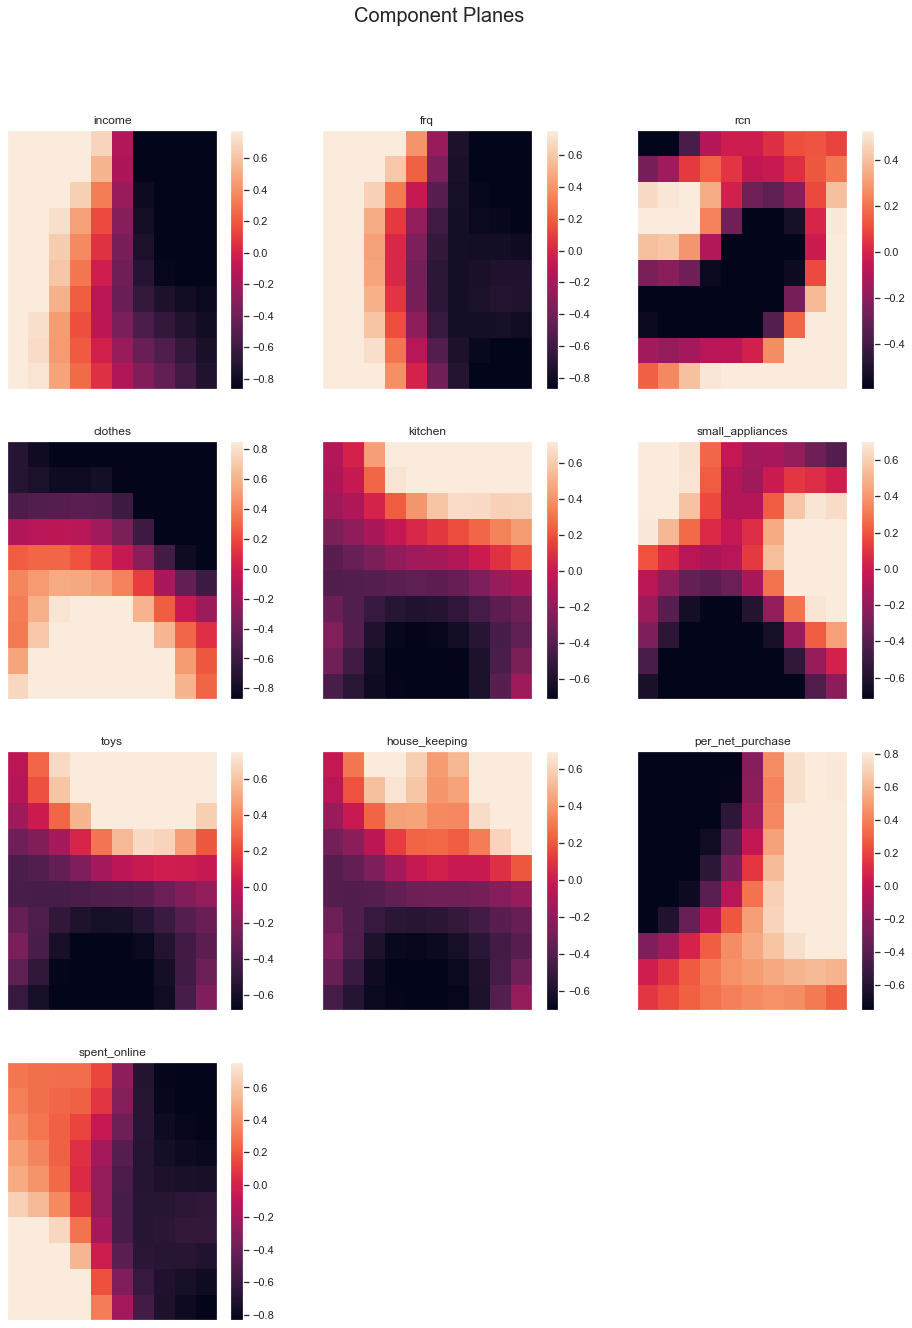

In [35]:
# Visualizing the Component planes (feature values)
sns.set()

view2D = View2D(12,12,"", text_size=10)
view2D.show(sm, col_sz=3, what='codebook')

plt.subplots_adjust(top=0.90)
plt.suptitle("Component Planes", fontsize=20)
plt.show()

## U-matrix
Encode each neuron in the output space with the **average distance** to its neighbors in the input space.

Analyse these plots from the following perspectives:
- Clusters of units
- Pontential outliers (units which are very distant from its neighbors and have low frequency)

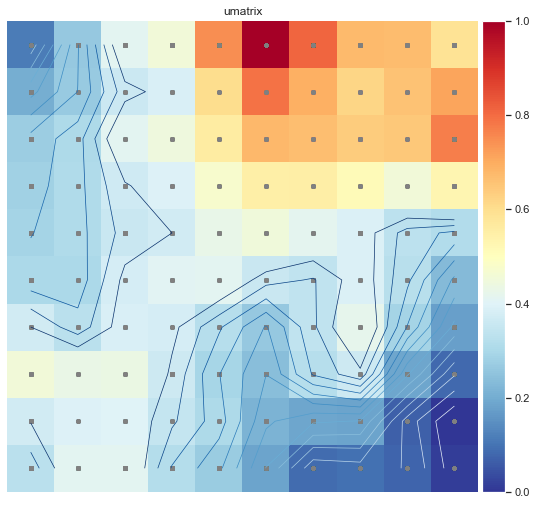

array([[0.57446755, 0.67787092, 0.78089614, 0.81004609, 1.01516417,
        1.18901695, 1.05694348, 0.96208691, 0.95893724, 0.9032989 ],
       [0.63601626, 0.67955129, 0.74582131, 0.7630978 , 0.91320375,
        1.04293258, 0.97650202, 0.92538003, 0.95199952, 0.98920802],
       [0.68577273, 0.70833856, 0.78160919, 0.80375686, 0.8838812 ,
        0.96376184, 0.95610472, 0.93734844, 0.94368946, 1.03002891],
       [0.69035773, 0.71030749, 0.75095132, 0.76964363, 0.82302593,
        0.87447412, 0.87905714, 0.85023702, 0.81146307, 0.86244539],
       [0.69693484, 0.71018022, 0.74115517, 0.75336207, 0.79139238,
        0.80710455, 0.78302571, 0.76555776, 0.7267734 , 0.71133375],
       [0.70527705, 0.7054141 , 0.75912699, 0.7784996 , 0.78032856,
        0.74212599, 0.7329446 , 0.76653737, 0.72063073, 0.65676989],
       [0.75341637, 0.7238274 , 0.76528159, 0.75946741, 0.71925327,
        0.6775752 , 0.73106884, 0.78499992, 0.69699495, 0.61859489],
       [0.80960228, 0.79365258, 0.7977050

In [36]:
# Here you have U-matrix
u = sompy.umatrix.UMatrixView(12, 12, 'umatrix', show_axis=True, text_size=8, show_text=True)

UMAT = u.show(
    sm, 
    distance=1, 
    row_normalized=False,
    show_data=True, 
    contour=True, # Visualize isomorphic curves
    blob=False
)

UMAT[1]  # U-matrix values - no colorscale so we have to rely on the values :(

### Hit-map
Show the **frequency** of each Unit in the output map

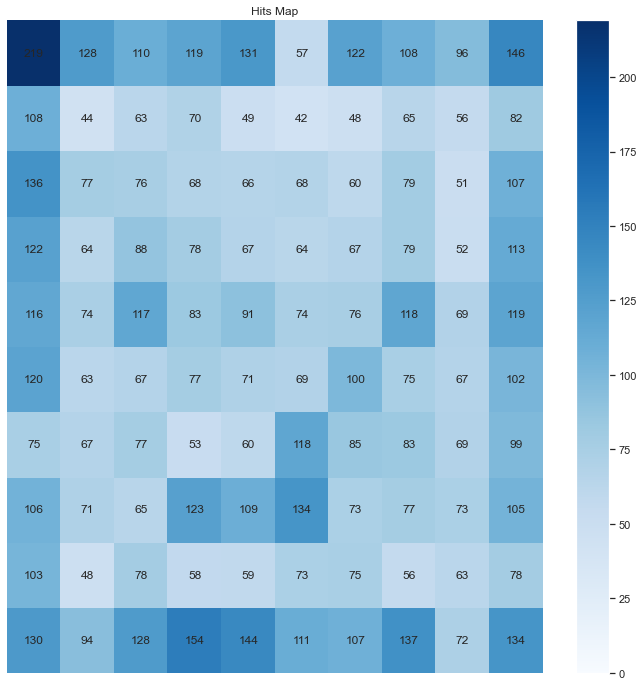

In [37]:
vhts  = BmuHitsView(12,12,"Hits Map")
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=12, cmap="Blues")
plt.show()

## Clustering with SOMs: K-means SOM vs Emergent SOM
- In **k-means SOM**, the *number of units should be equal to the expected number of clusters*, and thus each cluster should be represented by a single unit. 
- In **emergent SOM**, a very *large number of units is used*. These very large SOM allow for very clear U-Matrices and are useful for detecting quite clearly the underlying structure of the data. This technique can be **used together with other clustering algorithms**.

**Exercise**
- Train a SOM with a 50x50 grid, random initialization, gaussian neighborhood function and hexagonal topology/lattice
- Set an unfolding phase and a fine tuning phase of 100 iterations

In [38]:
# This som implementation does not have a random seed parameter
# We're going to set it up ourselves
np.random.seed(42)

# Notice that the SOM did not converge - We're under a time constraint for this class
sm = sompy.SOMFactory().build(
    df[metric_features].values, 
    mapsize=[50, 50], 
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='rect',
    component_names=metric_features
)
sm.train(n_job=-1, verbose='info', train_rough_len=100, train_finetune_len=100)

 Training...
 random_initialization took: 0.000000 seconds
 Rough training...
 radius_ini: 17.000000 , radius_final: 2.833333, trainlen: 100

 epoch: 1 ---> elapsed time:  0.224000, quantization error: 2.528420

 epoch: 2 ---> elapsed time:  0.295000, quantization error: 2.776946

 epoch: 3 ---> elapsed time:  0.271000, quantization error: 2.183159

 epoch: 4 ---> elapsed time:  0.311000, quantization error: 2.115796

 epoch: 5 ---> elapsed time:  0.279000, quantization error: 2.096222

 epoch: 6 ---> elapsed time:  0.293000, quantization error: 2.084408

 epoch: 7 ---> elapsed time:  0.313000, quantization error: 2.064316

 epoch: 8 ---> elapsed time:  0.288000, quantization error: 2.024294

 epoch: 9 ---> elapsed time:  0.282000, quantization error: 1.977978

 epoch: 10 ---> elapsed time:  0.276000, quantization error: 1.951700

 epoch: 11 ---> elapsed time:  0.306000, quantization error: 1.940686

 epoch: 12 ---> elapsed time:  0.284000, quantization error: 1.934335

 epoch: 13 --->

 epoch: 14 ---> elapsed time:  0.288000, quantization error: 1.305530

 epoch: 15 ---> elapsed time:  0.280000, quantization error: 1.302577

 epoch: 16 ---> elapsed time:  0.288000, quantization error: 1.299352

 epoch: 17 ---> elapsed time:  0.282000, quantization error: 1.296143

 epoch: 18 ---> elapsed time:  0.286000, quantization error: 1.292987

 epoch: 19 ---> elapsed time:  0.284000, quantization error: 1.289815

 epoch: 20 ---> elapsed time:  0.275000, quantization error: 1.286697

 epoch: 21 ---> elapsed time:  0.276000, quantization error: 1.283483

 epoch: 22 ---> elapsed time:  0.284000, quantization error: 1.280142

 epoch: 23 ---> elapsed time:  0.281000, quantization error: 1.276929

 epoch: 24 ---> elapsed time:  0.277000, quantization error: 1.273721

 epoch: 25 ---> elapsed time:  0.282000, quantization error: 1.270345

 epoch: 26 ---> elapsed time:  0.282000, quantization error: 1.266973

 epoch: 27 ---> elapsed time:  0.285000, quantization error: 1.263640

 epoch

In [40]:
# Coordinates of the units in the input space
sm.get_node_vectors()

AttributeError: 'SOM' object has no attribute 'get_node_vectors'

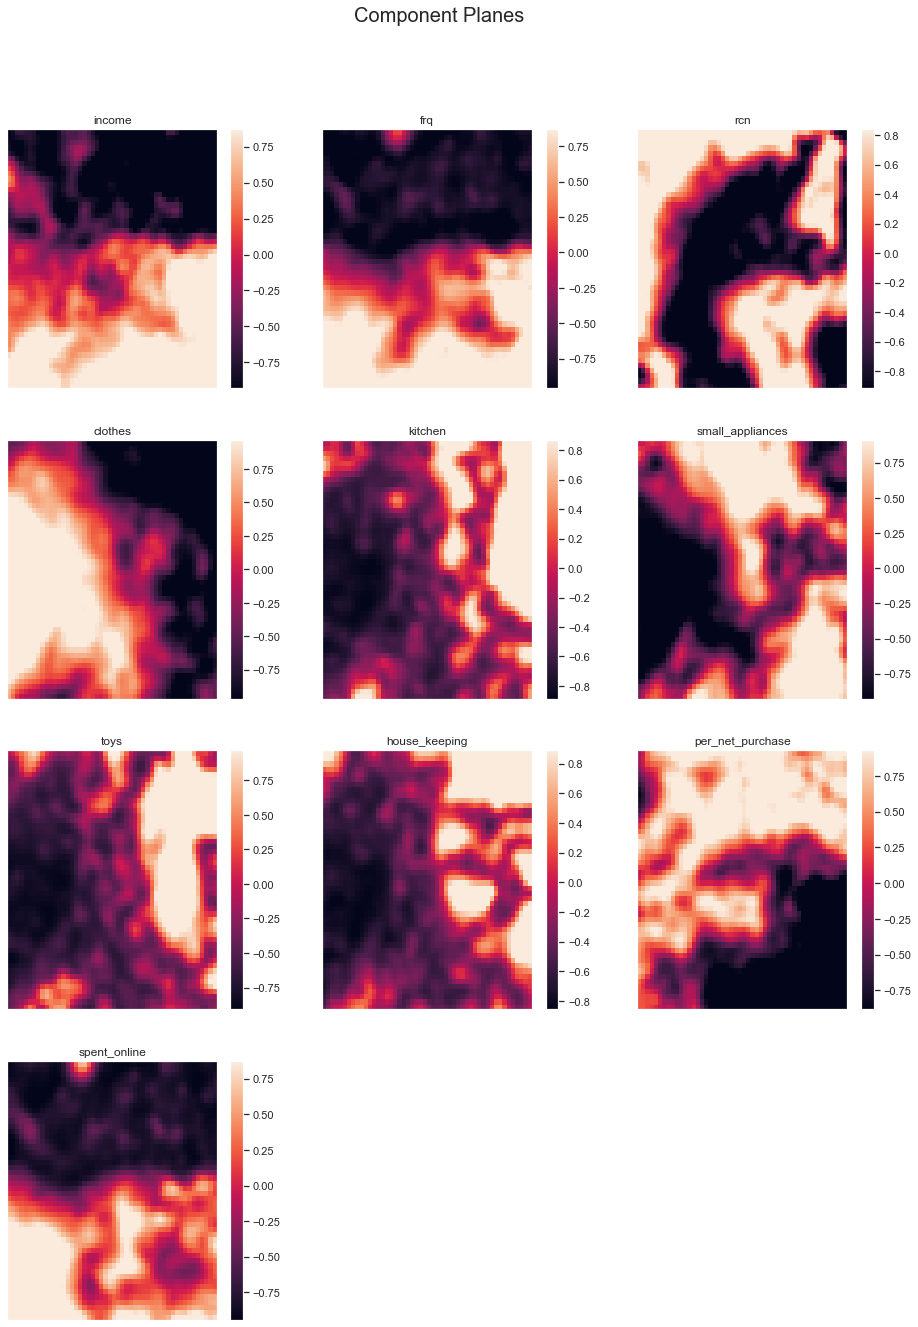

In [14]:
# Component planes on the 50x50 grid
sns.set()
view2D = View2D(12,12,"", text_size=10)
view2D.show(sm, col_sz=3, what='codebook')
plt.subplots_adjust(top=0.90)
plt.suptitle("Component Planes", fontsize=20)
plt.show()

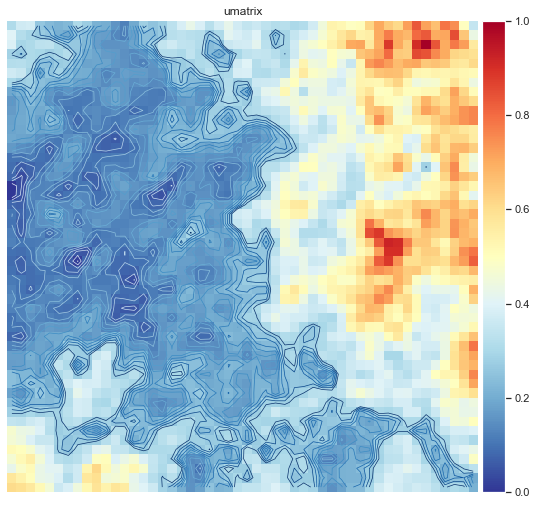

In [15]:
# U-matrix of the 50x50 grid
u = sompy.umatrix.UMatrixView(12, 12, 'umatrix', show_axis=True, text_size=8, show_text=True)

UMAT = u.show(
    sm, 
    distance=1, 
    row_normalized=False, 
    show_data=False, 
    contour=True # Visualize isomorphic curves
)

### K-Means on top of SOM units
- Define number of clusters to retain

In [16]:
# Do the Inertia plot here (check last class' notebook)

In [17]:
# Perform K-Means clustering on top of the 2500 untis (sm.get_node_vectors() output)
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=20, random_state=42)
nodeclus_labels = sm.cluster(kmeans)

hits  = HitMapView(12, 12,"Clustering", text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

TypeError: '<' not supported between instances of 'int' and 'KMeans'

### Hierarchical Clustering on top of SOM units
- Define best linkage method
- Define number of clusters to retain

In [18]:
# Do the R² plot here and the Dendrogram (check last class' notebook)

In [19]:
# Perform Hierarchical clustering on top of the 2500 untis (sm.get_node_vectors() output)
hierclust = AgglomerativeClustering(n_clusters=4, linkage='ward')
nodeclus_labels = sm.cluster(hierclust)

hits  = HitMapView(12, 12,"Clustering",text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

TypeError: '<' not supported between instances of 'int' and 'AgglomerativeClustering'

### Final SOM Clustering solution

In [20]:
# Check the nodes and and respective clusters
nodes = sm.get_node_vectors()

df_nodes = pd.DataFrame(nodes, columns=metric_features)
df_nodes['label'] = nodeclus_labels
df_nodes

AttributeError: 'SOM' object has no attribute 'get_node_vectors'

In [21]:
# Obtaining SOM's BMUs labels
bmus_map = sm.find_bmu(df[metric_features])[0]  # get bmus for each observation in df

df_bmus = pd.DataFrame(
    np.concatenate((df, np.expand_dims(bmus_map,1)), axis=1),
    index=df.index, columns=np.append(df.columns,"BMU")
)
df_bmus

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,...,x2_M,x3_1.0,x4_Kind of OK,x4_Meh...,x4_OK nice!,x4_Take my money!!,PC0,PC1,PC2,BMU
0,0.743162,1.191605,0.457819,-0.617023,-0.243065,1.216847,0.495837,-0.499274,-1.257560,0.522055,...,1.0,0.0,0.0,0.0,0.0,1.0,0.896356,1.937697,-1.120781,2237.0
1,1.559488,1.100011,-1.535723,0.166160,-0.790228,0.740464,-0.374374,-0.631907,-1.798649,-0.237578,...,0.0,0.0,0.0,0.0,0.0,1.0,1.981092,1.421498,-0.785625,2370.0
2,-1.548542,-0.823463,0.557496,-0.834573,1.672006,-0.371096,-0.809480,2.286023,0.906799,-0.904191,...,1.0,1.0,1.0,0.0,0.0,0.0,-2.813108,-0.381440,0.780867,33.0
3,0.845528,0.550447,-1.402820,0.383710,0.440889,-0.768082,-0.084304,-0.234007,-0.391816,0.785568,...,0.0,1.0,0.0,0.0,1.0,0.0,1.247013,0.514177,1.302203,2164.0
4,0.782435,1.008417,-0.871209,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,-0.445925,1.237135,...,0.0,1.0,0.0,0.0,0.0,1.0,1.781920,0.704805,0.443376,2111.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8812,0.618993,0.458853,-1.701851,0.209670,0.167308,-0.132905,0.205767,-0.764540,0.257492,1.275517,...,1.0,1.0,1.0,0.0,0.0,0.0,1.162525,0.372854,0.982963,2313.0
8813,0.874744,0.733635,-1.701851,0.731791,-0.243065,-0.609288,-0.519409,-0.366640,0.690363,1.865248,...,0.0,1.0,0.0,0.0,0.0,1.0,2.003026,-0.083121,1.428619,1911.0
8814,-0.455617,-0.731869,-1.535723,0.079139,-0.106274,-0.053508,0.060732,-0.101374,1.556107,-0.801266,...,1.0,1.0,0.0,1.0,0.0,0.0,-1.002171,-1.301747,0.423851,719.0
8815,-0.596155,0.825229,0.657173,-0.442982,0.577680,0.581670,-0.809480,0.561792,-0.608252,0.801051,...,1.0,0.0,0.0,0.0,0.0,1.0,0.130573,0.959962,-0.332242,1530.0


In [22]:
# Get cluster labels for each observation
df_final = df_bmus.merge(df_nodes['label'], 'left', left_on="BMU", right_index=True)
df_final

NameError: name 'df_nodes' is not defined

In [23]:
# Characterizing the final clusters
df_final.drop(columns='BMU').groupby('label').mean()

NameError: name 'df_final' is not defined

## Analysing the appropriateness of our solution
### R²

In [24]:
# using R²
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

sst = get_ss(df_final[metric_features])  # get total sum of squares
ssw_labels = df_final[metric_features.to_list() + ["label"]].groupby(by='label').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

NameError: name 'df_final' is not defined

### Quantization error:
The quantization error is given by the average distance between a unit and the data points mapped to it i.e. all the input data points that share it as BMU.

$$q_e = \frac{\sum_{i=0}^{N_e}||x_i - w_e||}{N_e}$$

$$Q = \frac{\sum_{e=0}^Eq_e}{E}$$
, where:

$Q$ is the overall quantization error of SOM,

$q_e$ is the quantization error for unit $e$,

$x_i$ is a data point/ observation,

$w_e$ is the unit $e$ representation in the input space,

$N_e$ is number of data points mapped to unit $e$,

$E$ is the number of units in the SOM grid